In [1]:
%pylab inline
import pandas as pd
import datetime as dt

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn import svm, ensemble, tree

In [3]:
udf = pd.read_csv('../data/2nd/tianchi_mobile_recommend_train_user_filtered.csv', index_col=['user_id', 'item_id'])
u = udf.reset_index()

In [33]:
rdf = pd.read_csv('../data/test/result12.csv')
print '限制样本总大小：', len(rdf)
t = u[(u.user_id.isin(rdf.user_id) | u.item_id.isin(rdf.item_id))]
print '过滤样本总大小：', len(t)

限制样本总大小： 578
过滤样本总大小： 85750


In [40]:
behavior_str = ['browse', 'collect', 'cart', 'buy']


def behavior_first_hour(df, date, behavior, label=None):
    ret = df[(df['date'] == date) & (df['behavior_type'] == behavior)].groupby(['user_id', 'item_id'])
    return ret.hour.min()


def behavior_day_times(df, date, behavior, label=None):
    ret = df[(df['date'] == date) & (df['behavior_type'] == behavior)].groupby(['user_id', 'item_id'])
    return ret.behavior_type.count()


def behavior_window_hour_times(df, date, hour, hour_window=1, behavior=1, label="%d-%d"):
    ret = df[(df['date'] == date) & (df['behavior_type'] == behavior) & 
             (df['hour'] >= hour) & (df['hour'] <= hour + hour_window)].groupby(['user_id', 'item_id'])
    return ret.hour.count()


def r2_user_item(df, date, days=5):
    today = dt.datetime.strptime(date, '%Y-%m-%d')
    prev_day = [
        (today - dt.timedelta(d)).strftime('%Y-%m-%d') for d in xrange(days)
    ]
    result = dict()
    for day in xrange(days):
        for behavior in [2, 3]:
            result["last_%d_%s" % (day, behavior_str[behavior - 1])] = behavior_first_hour(df, prev_day[day], behavior)
        result["last_%d_browse_times" % (day)] = behavior_day_times(df, prev_day[day], 1)
    rdf = pd.DataFrame(result)
    # 过滤当天购买的用户/商品对
    selected = df[(df['date'] == prev_day[0]) & (df['behavior_type'] != 4)].groupby(['user_id', 'item_id']).first()
    bought = df[(df['date'] == prev_day[0]) & (df['behavior_type'] == 4)].groupby(['user_id', 'item_id']).first()
    ret = rdf[rdf.index.isin(selected.index) & ~rdf.index.isin(bought.index)]
    # 填充缺失值
    na_columns = ret.columns.tolist()
    na = dict()
    for i in xrange(0, days * 3):
        na[na_columns[i]] = -1
    return ret.fillna(na)

In [234]:
def result_set(df, date):
    return set(df[(df.date == date) & (df.behavior_type == 4)].index)

In [405]:
def behavior_stats(df, date, hour, behavior):
    return df[(df.date == date) & (df.behavior_type == behavior) & (df.hour >= hour)].groupby(['user_id', 'item_id'])['behavior_type'].size()

def r3_data(df, date):
    today = dt.datetime.strptime(date, '%Y-%m-%d')
    ret = dict()
    for i in xrange(0, 1):
        d = (today - dt.timedelta(i)).strftime('%Y-%m-%d')
        for h in xrange(0, 24, 3):
            ret['browse_at_%d_%d' % (i, h)] = behavior_stats(df, d, h, 1)
            ret['mark_at_%d_%d' % (i, h)] = behavior_stats(df, d, h, 2)
            ret['cart_at_%d_%d' % (i, h)] = behavior_stats(df, d, h, 3)
            ret['buy_at_%d_%d' % (i, h)] = behavior_stats(df, d, h, 4)
    return pd.DataFrame(ret).fillna(False)

In [41]:
def extract_label(df, pred_date):
    tlabel = df[(df['date'] == pred_date)].groupby(['user_id', 'item_id']).max()
    tlabel['label'] = [1 if t == 4 else 0 for t in tlabel['behavior_type']]
    return tlabel[['label']]

In [5]:
def inspect(predict, actual):
    hits = len(filter(lambda a: a[0] == 1 and a[0] == int(a[1]), zip(predict, actual)))
    predicts = len(predict[predict == 1])
    actuals =len(filter(lambda d: d==1, test_data[:, -1]))
    precision = hits / float(predicts)
    recall = hits / float(actuals)
    print 'Hits:', hits
    print 'Predicts:', predicts
    print 'Actuals:', actuals
    print 'Precision:', precision

In [12]:
def sample_negative_positive(df, weight=5):
    """
    对数据集进行
    :param df: the data frame.
    :param weight: the weight of the negative set.
    :return: the sampled data frame.
    :rtype: pd.DataFrame
    """
    import random
    posdf = df[df['cla'] > 0]
    negdf = df[df['cla'] <= 0]
    seldf = negdf.ix[random.sample(negdf.index, len(posdf) * weight)]
    # for i in xrange(posrate):
    #     seldf = seldf.append(posdf)
    return seldf.append(posdf)

In [4]:
df14 = pd.read_csv('../data/sample/r3/apr23_train_2014-12-14_2nd_all_2.csv')
pdf14 = pd.read_csv('../data/sample/r3/apr23_train_2014-12-14_2nd_pos_2.csv')
df15 = pd.read_csv('../data/sample/r3/apr23_train_2014-12-15_2nd_all_2.csv')
pdf15 = pd.read_csv('../data/sample/r3/apr23_train_2014-12-15_2nd_pos_2.csv')
df16 = pd.read_csv('../data/sample/r3/apr23_train_2014-12-16_2nd_all_2.csv')
pdf16 = pd.read_csv('../data/sample/r3/apr23_train_2014-12-16_2nd_pos_2.csv')
df17 = pd.read_csv('../data/sample/r3/apr23_train_2014-12-17_2nd_all_2.csv')
pdf17 = pd.read_csv('../data/sample/r3/apr23_train_2014-12-17_2nd_pos_2.csv')
df18 = pd.read_csv('../data/sample/r3/apr23_train_2014-12-18_2nd_all_2.csv')
pdf18 = pd.read_csv('../data/sample/r3/apr23_train_2014-12-18_2nd_pos_2.csv')

## 数据准备

In [218]:
train_df = r2_user_item(u, '2014-12-16', 4).join(extract_label(u, '2014-12-17'), how='left').fillna(0)
train_data = train_df.values
test_df = r2_user_item(u, '2014-12-17', 4).join(extract_label(u, '2014-12-18'), how='left').fillna(0)
test_data = test_df.values

In [130]:
train_df = pd.read_csv('../data/sample/r1/apr22_train_2014-12-17.csv', index_col=['user_id', 'item_id'])
train_data = train_df.values
test_df = pd.read_csv('../data/sample/r1/apr22_test_2014-12-18.csv', index_col=['user_id', 'item_id'])
test_data = test_df.values

In [429]:
train_df = pd.read_csv('../data/train/apr10_2014-12-17.csv', index_col=['user_id', 'item_id'])
train_data = train_df.values
test_df = pd.read_csv('../data/train/apr10_2014-12-18.csv', index_col=['user_id', 'item_id'])
test_data = test_df.values

In [406]:
train_df = r3_data(u, '2014-12-16').join(extract_label(u, '2014-12-17'), how='left').fillna(0)
train_data = train_df.values
test_df = r3_data(u, '2014-12-17').join(extract_label(u, '2014-12-18'), how='left').fillna(0)
test_data = test_df.values

In [13]:
train_df = df17
for i in xrange(1): train_df = train_df.append(sample_negative_positive(df14, 2))
for i in xrange(2): train_df = train_df.append(sample_negative_positive(df15, 2))
for i in xrange(4): train_df = train_df.append(sample_negative_positive(df16, 2))
train_data = train_df.set_index(['user_id', 'item_id']).values
test_df = df18
test_data = test_df.set_index(['user_id', 'item_id']).values

In [25]:
train_df.to_csv('../data/sample/r3/train_1.csv')
test_df.to_csv('../data/sample/r3/test_1.csv')

In [ ]:
print '正样本数：\t', len(train_df[train_df.label == 1])
print '正样本比例：\t', len(train_df[train_df.label == 1]) / float(len(train_df))
print '非重复正样本数：\t', len(train_df[train_df.label == 1].drop_duplicates())
print '非重复正样本比例：\t', len(train_df[train_df.label == 1].drop_duplicates()) / float(len(train_df[train_df.label == 0].drop_duplicates()))
print '非重复样本数：\t', len(train_df.drop_duplicates())
print '非重复比例：\t', len(train_df.drop_duplicates()) / float(len(train_df))

In [418]:
train_df = train_df[train_df.label == 1].append(train_df[train_df.label == 0].drop_duplicates())
train_data = train_df.values

## 分类器分类

In [439]:
svc = svm.SVC(class_weight={1: 100, 0: 1})

In [15]:
gbdt = ensemble.GradientBoostingClassifier(max_depth=10, max_features='log2')

In [441]:
dt = tree.DecisionTreeClassifier(criterion='entropy', class_weight={1: 50, 0: 1}, max_depth=10)

In [ ]:
for l in zip(train_df.columns, clf.feature_importances_):
    print l[0],':',l[1]

In [ ]:
u[(u.user_id ==4913) & (u.item_id == 12265214)].sort(['date', 'hour'])

## 预测与验证

In [16]:
def check(clf, train_data, test_data):
    clf.fit(train_data[:, :-1], train_data[:, -1])
    inspect(clf.predict(test_data[:, :-1]), test_data[:, -1])

In [443]:
check(dt, train_data, test_data)

Hits: 74
Predicts: 4408
Actuals: 144
Precision: 0.0167876588022


In [17]:
check(gbdt, train_data, test_data)

Hits: 8
Predicts: 169
Actuals: 144
Precision: 0.0473372781065


In [ ]:
check(svc, train_data, test_data)

In [27]:
reference = pd.read_csv('../data/test/result12.csv', index_col=['user_id', 'item_id'])
refset = set(reference.index)

In [28]:
rdf = reference.reset_index().set_index('user_id')

In [29]:
rdf[~rdf.index.isin(u[(u.behavior_type == 4) & (u.date == '2014-12-18')].user_id)]

,item_id
user_id,
128289511,8303636
17048049,272600691
17048049,26248191
138390959,145668358
120305341,276935287
83954147,206665850
83954147,100095537
124259296,243249090
51013339,310833686


In [32]:
len(rdf)

578

In [34]:
rdf[~rdf.index.isin(u[(u.behavior_type == 4) & (u.date == '2014-12-18')].user_id)].size

447

In [87]:
g = u[u.behavior_type == 4].groupby(['user_id'])

In [42]:
u['date'] = u['date'].map(lambda d: dt.datetime.strptime(d, '%Y-%m-%d'))

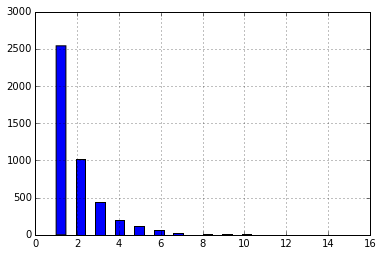

In [46]:
g.date.nunique().hist(bins=30)

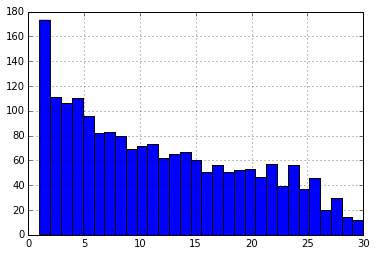

In [84]:
tdelta = (g.date.max() - g.date.min())
tdelta[tdelta>0].dt.days.hist(bins=30)

In [117]:
def avg_delta(g):
    a = g.sort(['date'], ascending=False)['date']
    if len(a) > 1:
        return (a[:-1].reset_index()['date'] - a[1:].reset_index()['date']).median()
    else:
        return pd.Timedelta(days=0)
ret = g.apply(avg_delta).dropna()

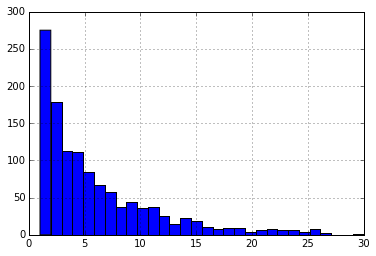

In [121]:
ret[ret.dt.days>0].dt.days.hist(bins=30)

In [122]:
result12 = pd.read_csv('../data/test/result12.csv', index_col=['user_id', 'item_id'])
result13 = pd.read_csv('../data/test/result13d1.csv', index_col=['user_id', 'item_id'])

In [123]:
rset12 = set(result12.index)
rset13 = set(result13.index)

In [329]:
predict = pd.read_csv('../data/sample/apr23_predict_2014-12-18_1.csv', index_col=['user_id', 'item_id'])

In [146]:
predict.reset_index(inplace=True)

In [338]:
predict['user_buy_sum'] = predict.user_beh4_at1 + predict.user_beh4_at2 + predict.user_beh4_at3
predict['item_buy_sum'] = predict.item_beh4_at1 + predict.item_beh4_at2 + predict.item_beh4_at3

In [213]:
g1 = udf[udf.index.isin(rset12 - rset13)].reset_index().sort(['user_id', 'item_category', 'date', 'hour'])

In [343]:
g1.reset_index(inplace=True)

In [134]:
g1.to_csv('../data/sample/analytic.csv')

In [202]:
predict['item_buy_sum'] = predict.item_beh4_at1 + predict.item_beh4_at2 + predict.item_beh4_at3

In [344]:
sel = pd.merge(
    pd.merge(
        g1, 
        predict[['user_id', 'userbrowseToBuyRate1', u'userbrowseToBuyRate2', u'usercartToBuyRate1', u'usercartToBuyRate2', u'usercollectToBuyRate1', u'usercollectToBuyRate2', 'user_buy_sum']].drop_duplicates(),
        how='left', on=['user_id']
    ),
    predict[['item_id', u'itemBrowseToBuyRate1', u'itemBrowseToBuyRate2', u'itemCartToBuyRate1', u'itemCartToBuyRate2', u'itemCollectToBuyRate1', u'itemCollectToBuyRate2', u'item_beh4_at1', 'item_beh4_at2', 'item_beh4_at3', 'item_buy_sum']].drop_duplicates(),
    how='left', on=['item_id']
).set_index(['user_id', 'item_id'])

In [220]:
len(set(sel[(sel.itemCartToBuyRate2 > 0.4) & (sel.itemCartToBuyRate1 >= 0)].index))

18

In [221]:
idx = set(sel[(sel.itemCartToBuyRate2 > 0.3) & (sel.itemCartToBuyRate1 >= 0)].index)

In [222]:
sel[sel.index.isin(idx)].to_csv('../data/sample/analytic1.csv')

In [347]:
sel.reset_index(inplace=True)

In [373]:
def df18_manual_filter(sel):
    def df18_selu(df):
        n = int(min(math.ceil(df.item_id.nunique() * 0.2), 2))
        del df['user_id']
        del df['item_category']
        return df.groupby(['item_id']).agg(dict(
                behavior_type='count',
                item_buy_sum='first',
                itemCartToBuyRate1='first',
                itemCartToBuyRate2='first'
            )).sort(['item_buy_sum', 'itemCartToBuyRate1', 'itemCartToBuyRate2'], ascending=False).head(n)
    selu = sel.groupby(['user_id', 'item_category']).apply(df18_selu)
    uset = set(selu.reset_index().set_index(['user_id', 'item_id']).index)
    print 'Records(selu):', len(uset)

    def df18_seli(df):
        n = int(min(math.ceil(df.user_id.nunique() * 0.3), 2))
        del df['item_id']
        return df.groupby(['user_id']).agg(dict(
                behavior_type='count',
                user_buy_sum='first',
                usercartToBuyRate1='first',
                usercartToBuyRate2='first'
            )).sort(['user_buy_sum', 'usercartToBuyRate1', 'usercartToBuyRate2'], ascending=False).head(n)
    seli = sel.groupby(['item_id']).apply(df18_seli)
    iset = set(seli.reset_index().set_index(['user_id', 'item_id']).index)
    print 'Records(seli):', len(iset)

    print 'Intersection:', len(uset.intersection(iset))
    
    return uset.intersection(iset)

In [374]:
ret = df18_manual_filter(sel)

Records(selu): 85
Records(seli): 131
Intersection: 85


In [372]:
rset3 = df18_manual_filter(pd.read_csv('../data/data_1/apr23_train_2014-12-18_2nd_all_2.csv'))

KeyError: 'item_category'

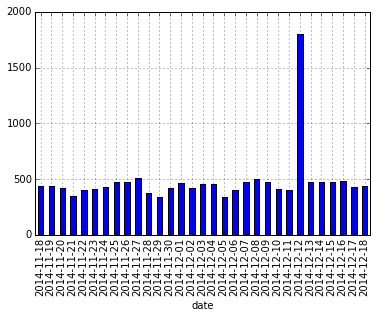

In [362]:
g = udf[udf.behavior_type==4].groupby('date').behavior_type.size()
g.plot(kind='bar')

In [279]:
len(set(seli.reset_index().set_index(['user_id', 'item_id']).index))

109

In [298]:
rs1 = selg[selg.usercartToBuyRate1 > 0.2]#.to_csv('../data/sample/sel_r1.csv')

In [281]:
predict.set_index(['user_id', 'item_id'], inplace=True)
g1.set_index(['user_id', 'item_id'], inplace=True)
subpredict = predict[predict.index.isin(g1.index)]

In [283]:
from sklearn import cluster

In [288]:
mbm = cluster.MiniBatchKMeans(n_clusters=2)
mbml = mbm.fit_predict(subpredict.values)

In [289]:
subpredict1 = subpredict.copy()
subpredict1['label'] = mbml

In [290]:
subpredict1.to_csv('../data/sample/analytic2.csv')

In [303]:
len(subpredict1[subpredict1.label == 1])

59

In [324]:
model = cluster.KMeans(n_clusters=2) #cluster.AffinityPropagation(damping=1)
label = model.fit_predict(subpredict.values)
subpredict1 = subpredict.copy()
subpredict1['label'] = label
rset1 = set(rs1.reset_index().set_index(['user_id', 'item_id']).index)
rset2 = set(subpredict1[subpredict1.label == 1].index)
print subpredict1.label.nunique(), len(rset1), len(rset2), len(rset2.intersection(rset1))
subpredict1[subpredict1.isin(rset2.intersection(rset1))].to_csv('../data/sample/analytic3.csv')

2 45 72 27


In [336]:
subpredict[subpredict.index.isin(rset1.intersection(rset2))]

0_0-1  0_1-2  0_2-3  0_3-4  0_4-5  0_5-6  0_6-7  0_7-8  \
user_id   item_id                                                             
72295163  2949500        0      0      0      0      0      0      0      0   
          179571505      0      0      0      0      0      0      0      0   
64471307  166976717      0      0      0      0      0      0      0      0   
69462679  2395525        0      0      0      0      0      0      0      0   
          84259565       0      0      0      0      0      0      0      0   
118282748 193357920      0      0      0      0      0      0      0      0   
87942719  66089865       0      0      0      0      0      0      0      0   
          10563085       0      0      0      0      0      0      0      0   
          36849883       0      0      0      0      0      0      0      0   
          60710911       0      0      0      0      0      0      0      0   
          138330683      0      0      0      0      0      0      0      0   
          157381080      0      0      0      0      0      0      0      0   
          185280170      0      0      0      0      0      0      0      0   
71714329  170968016      0      0      0      0      0      3      3      0   
36110156  132533259      0      0      0      0      0      0      0      0   
110007607 78138380       0      0      0      0      0      0      0      0   
          21404978       0      0      0      0      0      0      0      0   
130216411 113436129      0      0      0      0      0      0      0      0   
69255232  139503169      0      0      0      0      0      0      0      0   
109179391 138111309      0      0      0      0      0      0      0      0   
100684618 44072438       0      0      0      0      0      0      0      0   
49003690  147440856      0      0      0      0      0      0      0      0   
137362349 76000005       0      0      0      0      0      0      0      0   
          184479647      0      0      0      0      0      0      0      0   
108546559 73430329       0      1      1      0      0      0      0      0   
126086100 76381429       0      0      0      0      0      0      0      0   
128180595 195045826      0      0      0      0      0      0      0      0   

                     0_8-9  0_9-10      ...       item_beh2_at1  \
user_id   item_id                       ...                       
72295163  2949500        0       0      ...                   1   
          179571505      0       0      ...                   0   
64471307  166976717      0       0      ...                   0   
69462679  2395525        0       6      ...                   0   
          84259565       0       0      ...                   0   
118282748 193357920      0       0      ...                   1   
87942719  66089865       0       0      ...                   0   
          10563085       0       0      ...                   1   
          36849883       0       0      ...                   0   
          60710911       0       0      ...                   0   
          138330683      0       0      ...                   0   
          157381080      0       0      ...                   0   
          185280170      0       0      ...                   0   
71714329  170968016      0       0      ...                   0   
36110156  132533259      0       0      ...                   0   
110007607 78138380       0       0      ...                   1   
          21404978       0       0      ...                   0   
130216411 113436129      0       0      ...                   0   
69255232  139503169      0       0      ...                   0   
109179391 138111309      0       0      ...                   0   
100684618 44072438       0       0      ...                   0   
49003690  147440856      0       0      ...                   0   
137362349 76000005       0       0      ...                   0   
          184479647      0       0      ...           

In [323]:
buys = udf[(udf.date == '2014-12-18') & (udf.hour >= 17) & (udf.behavior_type == 4)]
carts = udf[(udf.date == '2014-12-18') & (udf.hour >= 17) & (udf.behavior_type == 3)]
print len(set(carts[~carts.index.isin(buys.index)].index))

579


In [249]:
g1[(g1.user_id==6177572) & (g1.item_category==13500)]

,user_id,item_id,behavior_type,user_geohash,item_category,hour,date
24,6177572,323830543,1,NaN,13500,22,2014-12-10
85,6177572,323830543,1,NaN,13500,22,2014-12-10
337,6177572,323830543,1,NaN,13500,22,2014-12-10
181,6177572,323830543,3,95wjlh7,13500,13,2014-12-11
549,6177572,323830543,1,95wjlhw,13500,13,2014-12-11
738,6177572,323830543,1,95wjl7l,13500,13,2014-12-11
86,6177572,323830543,1,95wjlhn,13500,21,2014-12-15
338,6177572,323830543,1,95wjl7i,13500,21,2014-12-15
736,6177572,323830543,1,95wjl76,13500,21,2014-12-15
737,6177572,323830543,1,95wjl7f,13500,21,2014-12-15
